In [1]:
%pip install tenseal
%pip install -U scikit-learn
#!pip install pympler
#!pip install numpy
%pip install matplotlib
#!pip install fuzzy-c-means

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import copy
import time
import numpy as np
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import itertools
import random
#from fcmeans import FCM
import tenseal as ts
#from pympler import asizeof

In [3]:
def fuzzy_c_means(n_clusters, data):
    my_model = FCM(n_clusters=n_clusters,m=3)
    my_model.fit(np.transpose(data)) ## X, numpy array. rows:samples columns:features
    labels_data = [0]*data.shape[1]
    labels_centers = [1]*(my_model.centers.shape[0])
    labels = labels_data + labels_centers
    X = np.concatenate((data,my_model.centers),axis=None)
    #print_fig(X, labels, "real fuzzy_c_means")
    return my_model.centers


def real_kmeans(n_clusters, data):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(np.array(data))

    labels_data = [0]*len(data)
    labels_centers = list(range(1, len(kmeans.cluster_centers_) + 1))
    X = data + list(kmeans.cluster_centers_)
    x_data = [row[0] for row in X]
    y_data = [row[1] for row in X]
    colors = labels_data + labels_centers
    #print_fig(x_data, y_data, "Real kMeans", iteration=0, colors=colors, tochange=True)

    return kmeans

In [4]:
def get_TenSEAL_context():
  # parameters
  #poly_mod_degree = 8192
  poly_mod_degree = 16384
  #poly_mod_degree = 32768
  #coeff_mod_bit_sizes = [45, 21, 21, 21, 21, 21, 21, 45]
  coeff_mod_bit_sizes = [60, 40, 40, 40, 40, 40, 40, 60]
  #coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
  #coeff_mod_bit_sizes = [48, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]
  #coeff_mod_bit_sizes = [35,25,25,25,25,25,25,25,25,25,35]
  #coeff_mod_bit_sizes = [60, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 60]
  #coeff_mod_bit_sizes = [60, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 60]

  #print("sum of coeff_mod_bit_sizes=", sum(coeff_mod_bit_sizes))


  # create TenSEALContext
  ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1 ,coeff_mod_bit_sizes)


  #ctx_training.global_scale = 2 ** 21
  ctx_training.global_scale = 2 ** 40
  ctx_training.generate_galois_keys()
  #context.generate_relin_keys()
  return ctx_training

global context
context = get_TenSEAL_context()

In [5]:
def refresh_context(encrypted_data, message='', print_content=False):
  #print("Refreshing...")
  list_type = isinstance(encrypted_data, list)
  if not list_type:
    encrypted_data = [encrypted_data]

  plaintext_data = decrypt_data(encrypted_data)
  if print_content:
    #delete later
    if (',' in message and message.split()[1] == "approx") : print("1/approx: {}".format(1/plaintext_data[1][0]))
    print("{}: {}".format(message, plaintext_data))

  chipertext_data = encrypt_data(plaintext_data)
  if not list_type:
    return chipertext_data[0]

  return chipertext_data

In [32]:
def print_fig(X, Y, plot_name, iteration=0, colors=None, tochange=None):
    # Create a scatter plot
    fig, axs = plt.subplots(nrows=1, ncols=1)
    #centers_colors = [(item+1) for item in centers_colors]
    if colors is None:
      axs.scatter(x=X, y=Y, c=Y)
    else:
      axs.scatter(x=X, y=Y, c=colors)
    if iteration==0:
      axs.set_title(plot_name)
    else:
      axs.set_title(plot_name + ": iteration={}".format(iteration))
    if tochange is None:
      axs.set_ylim(-1, 6)
      axs.set_xlim(0, 1)
      fig.set_figheight(1.5)
    else:
      axs.set_ylim(0, 1)
      axs.set_xlim(0, 1)
    fig.show()


def plot_figures(data, centers, title, iteration=0, tochange=True, is_pp_case=False):
  if is_pp_case:
    data = decrypt_data(data)
    centers = decrypt_data(centers)
    title = "PP: " + title
  labels_data = [0]*len(data)
  labels_centers = list(range(1, len(centers) + 1))
  X = data + centers
  x_data = [row[0] for row in X]
  y_data = [row[1] for row in X]
  colors = labels_data + labels_centers
  print_fig(X = x_data, Y = y_data, plot_name=title, iteration=iteration, colors=colors, tochange=tochange)


def plot_final_result(data, cluster_centers, cluster_labels, title, dataset, is_pp_case=False):
    if is_pp_case:
        data = decrypt_data(data)
        centers = decrypt_data(centers)
    
    # Plot the data points and cluster centers
    data = np.array(data)
    cluster_centers = np.array(cluster_centers)
    plt.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='viridis')
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=100, c='red', label='Cluster Centers')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title(f'Clustering Results: {title} for {dataset}')
    plt.legend()
    plt.show()


In [7]:
def is_new_center_2d(temp_center, known_centers, known_intervals):
  for center_index in range(len(known_centers)):
    checked_center_location = known_centers[center_index]
    checked_center_interval = known_intervals[center_index]

    temp_center_x = temp_center[0]
    temp_center_y = temp_center[1]

    checked_center_x = checked_center_location[0]
    checked_center_y = checked_center_location[1]

    temp_calc = (temp_center_x - checked_center_x) ** 2 + (temp_center_y - checked_center_y) ** 2
    #(x - center_x)² + (y - center_y)² < radius²

    if temp_calc <= checked_center_interval ** 2:
      return (False, checked_center_location, checked_center_interval, center_index)
  return (True, -1, -1, -1)

In [8]:
def distance_2d(a, b, is_pp_case=False):
  #pitagoras without the square root
  if is_pp_case:
    c = a - b
    d = c.dot(c)
    return d

  return ((a[0]-b[0]) ** 2) + ((a[1]-b[1]) ** 2)


#efficient powering, takes log(p) calculations
# the following power function saves a single multiplication if exponent is an odd number
def power(base, exponent):
  if exponent == 2:
    return base * base
  if exponent % 2 == 1:
      result = base
      can_skip = True
  else:
      result = 1
      can_skip = False

  while exponent > 0:
      if exponent % 2 == 1:
          if can_skip:
            can_skip = False
          else:
            result *= base
      base *= base
      exponent //= 2
  return result


def get_normalized_sum_distance_p(sum_distance_p, p, n, num_of_points = 1, is_pp_case=False):
  normalize_factor = (1 / (power(2, p) * num_of_points) )
  normalized_sum_distance_p = sum_distance_p * normalize_factor
  if is_pp_case:
    normalized_sum_distance_p = refresh_context(normalized_sum_distance_p, "normalized_sum_distance_p")
  normalized_approx = inverse(normalized_sum_distance_p, n, is_pp_case)
  approx = normalized_approx * normalize_factor
  if is_pp_case:
    approx = refresh_context(approx, "approx")
  return approx


#def get_p_value(dis_p, sum_distance_p, p, n, num_of_points = 1):
  #normalize_factor = (1 / (power(math.sqrt(2), p) * num_of_points) )
  #normalize_factor = (1 / (power(2, p) * num_of_points) )
  #normalized_sum_distance_p = sum_distance_p * normalize_factor
  #normalized_approx = inverse(normalized_sum_distance_p, n)
  #approx = normalized_approx * normalize_factor

def get_p_value(dis_p, approx, is_pp_case=False):
  if is_pp_case:
    dis_p, approx = refresh_context([dis_p, approx], "dis_p, approx")

  prob = dis_p * approx

  if is_pp_case:
    prob = refresh_context(prob, "prob")

  return prob


def inverse(x, n, is_pp_case=False):
    #print("x: ", x)
    #if not is_pp_case:
        #return 1/x
    a = 2 - x
    b = 1 - x
    for i in range(n):
        b = b ** 2
        if is_pp_case:
          a, b = refresh_context([a, b], "[a, b]")
        a = a * (1 + b)
    return a

In [9]:
def prob_to_be_in_center_2d(data, centers, p,n, is_pp_case):
  num_of_centers = len(centers)
  num_of_points = len(data)
  distances_p = []
  sum_distance_p_from_centers = []
  for c in centers:
      dises = []
      for x in data:
            dis = distance_2d(x, c, is_pp_case)
            dises.append(dis)

      #all_dis_per_center = [(max(dises) - item + 0.05) for item in dises]
      #all_dis_per_center = [(2 - item + 0.05) for item in dises]
      all_dis_per_center = [(2 - item) for item in dises]

      all_dis_p_per_center = []
      sum_distance_p_from_single_center = 0
      for item in all_dis_per_center:
        if is_pp_case:
          item = refresh_context(item, "item")
        powered_item = power(item, p)
        if is_pp_case:
          powered_item = refresh_context(powered_item, "powered_item")
        all_dis_p_per_center.append(powered_item)
        sum_distance_p_from_single_center += powered_item

      distances_p.append(all_dis_p_per_center)
      sum_distance_p_from_centers.append(sum_distance_p_from_single_center)


  probs = []
  p_values_sum = []

  for i in range(num_of_centers):
    probs_sum = [0, 0]
    p_values_sum_per_center = 0
    approx = get_normalized_sum_distance_p(sum_distance_p_from_centers[i], p, n, num_of_points, is_pp_case)
    for j in range(num_of_points):
        if is_pp_case:
          #print("distances_p[i][{}] = {}, 1/approx = {}".format(j, distances_p[i][j], 1/approx))
          distances_p[i][j], approx = refresh_context([distances_p[i][j], approx], "distances_p[i][j], approx", print_content=False)
        p_value = get_p_value(distances_p[i][j], approx, is_pp_case)

        if is_pp_case:
          p_value = refresh_context(p_value, "p_value")
          temp_point_contrib = data[j] * p_value
          probs_sum = probs_sum + temp_point_contrib
        else:
          temp_point_contrib = [item * p_value for item in data[j]]
          probs_sum = [x + y for x, y in zip(probs_sum, temp_point_contrib)]

        p_values_sum_per_center = p_values_sum_per_center + p_value
    probs.append(probs_sum)
    p_values_sum.append(p_values_sum_per_center)

  #if is_pp_case:
    #p_values_sum = refresh_context(p_values_sum, "p_values_sum", print_content=True)
  #else:
    #print("p_values_sum: ", p_values_sum)

  return probs, p_values_sum

In [10]:
def run_one_mean_2d(data, n, initial_p, final_p, iterations, to_print, to_draw, to_draw_milestones, is_pp_case):
    #generate random center
    centers = [[random.uniform(0, 1), random.uniform(0, 1)]]
    if is_pp_case:
      centers = encrypt_data(centers)

    #plot the start position
    if to_draw_milestones:
      plot_figures(data, centers, "Our kMeans 2D: Start Position", iteration=0, tochange=True, is_pp_case=is_pp_case)

    #first iteration
    p = initial_p
    start = time.time()
    probs, p_values_sum = prob_to_be_in_center_2d(data, centers, p, n, is_pp_case)
    new_centers = probs
    
    if is_pp_case:  
      new_centers = refresh_context(new_centers, "Internal iteration #{}, new_centers".format(1), print_content=True)
      #print("new_centers: {}, iteration #{}".format(new_centers, 1))
    #else:
      #new_centers = [[(item/p_values_sum[c_index]) for item in probs[c_index]] for c_index in range(len(centers))]
    end = time.time()

    if to_print:
      print("({}/{}) centers = {}, Duration: {} seconds".format(1, iterations, new_centers, end - start))

    for i in range(1, iterations):
        start = time.time()

        if i == 3:
            new_centers[0] = add_noise_to_point(new_centers[0], is_pp_case)
            #new_centers[0] = new_centers[0] + [-0.1, -0.1]
            p = final_p
            
            
        probs, p_values_sum = prob_to_be_in_center_2d(data, new_centers, p, n, is_pp_case)
        new_centers = probs
        
        if is_pp_case:
          new_centers = refresh_context(new_centers, "Internal iteration #{}, new_centers".format(i+1), print_content=True)
          #print("new_centers: {}, iteration #{}".format(new_centers, i+1))

        #else:
          #new_centers = [[(item/p_values_sum[c_index]) for item in probs[c_index]] for c_index in range(len(centers))]
        end = time.time()

        if to_print:
          print("({}/{}) centers = {}, Duration: {} seconds".format(i+1, iterations, new_centers, end - start))
        if to_draw:
          plot_figures(data, new_centers, "Our kMeans 2D", iteration=i, tochange=True, is_pp_case=is_pp_case)

    #plot the final position
    if to_draw_milestones:
      plot_figures(data, new_centers, "Our kMeans 2D: Final Position", iteration=0, tochange=True, is_pp_case=is_pp_case)

    return new_centers[0]

In [11]:
def new_kmeans_2d(data, k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones = False, is_pp_case = False):
  final_centers = []
  final_intervals = []
  original_data = data.copy()
  #data = data.copy()

  #calculating center number i from total k
  for current_center_index in range(k ** 2):
    print("Looking for center number {}".format(len(final_centers) + 1))
    current_interval = interval

    for i in range(iterations_for_center):
      if len(data) == 0:
        break

      if is_pp_case:
        # Encrypt Data
        data = encrypt_data(data)

      temp_center = run_one_mean_2d(data, n, initial_p, final_p, internal_iterations, to_print, to_draw, to_draw_milestones, is_pp_case)

      if is_pp_case:
        # Decrypt Data
        temp_center = decrypt_data([temp_center])[0]
        data = decrypt_data(data)


      check_if_new_center = is_new_center_2d(temp_center, final_centers, final_intervals)
      is_search_stopped = check_if_new_center[0]
      prev_center = check_if_new_center[1]
      prev_interval = check_if_new_center[2]
      prev_center_index = check_if_new_center[3]
      if is_search_stopped:
        # the new center is far from the previous centers
        # meaning we have found a new center, save it
        # move to the next one
        final_centers.append(temp_center)
        final_intervals.append(current_interval)
        data = remove_data_around_center(data, temp_center, current_interval)
        if to_print:
            print("Found {} Centers so far:\n{}".format(len(final_centers), final_centers))

        if to_draw_milestones:
          plot_figures(original_data, final_centers, "Our kMeans 2D: Found {} Centers so far:\n{}".format(len(final_centers),final_centers), iteration=0, tochange=True, is_pp_case=False)
        break

      # we got to an existing cluster which already has a center
      # so we would like to start searching again
      # remove data around previous center and double the previous interval

      doubled_interval = 2 * prev_interval
      data = remove_data_around_center(data, prev_center, doubled_interval)
      #todo, update the new doubled interval for previous center
      final_intervals[prev_center_index] = doubled_interval
    
    # found all K centers
    if len(final_centers) == k:
        break


  #plot_figures(original_data, final_centers, "Our kMeans 2D: TADAM", iteration=0, tochange=True, is_pp_case=False)
  return final_centers

In [12]:
def remove_data_around_center(data, center, interval):
  updated_data = []
  center_x = center[0]
  center_y = center[1]

  for point in data:
    point_x = point[0]
    point_y = point[1]

    #(x - center_x)² + (y - center_y)² < radius²
    temp_calc = (point_x - center_x) ** 2 + (point_y - center_y) ** 2

    if temp_calc > interval ** 2:
      updated_data.append(point)

  return updated_data

In [13]:
def generate_data_points(center, radius, num_points):
    data_points = []
    cx, cy = center

    for _ in range(num_points):
        angle = random.uniform(0, 2 * math.pi)
        distance = random.uniform(0, radius)
        x = cx + distance * math.cos(angle)
        y = cy + distance * math.sin(angle)
        if 0 < x < 1 and 0 < y < 1:
          data_points.append([x, y])

    return data_points


def generate_data_circles(k, radius_range=[0.05, 0.2], num_points_range=[10,50]):
  generated_data = []

  for i in range(k):
    center = [random.uniform(0, 1), random.uniform(0, 1)]
    radius = random.uniform(radius_range[0], radius_range[1])
    num_points = random.randint(num_points_range[0], num_points_range[1])
    generated_data += generate_data_points(center, radius, num_points)

  return generated_data

def add_noise_to_point(point, is_pp_case = False):
    noise_x = random.uniform(-0.05, 0.05)
    noise_y = random.uniform(-0.05, 0.05)
    if is_pp_case:
        noisy_point = point + [noise_x, noise_y]
    else:
        noisy_point = [point[0] + noise_x, point[1] + noise_y]
    return noisy_point

In [14]:
def encrypt_data(data):
  encrypted_data = []
  #context = get_TenSEAL_context()
  encrypted_data = [ts.ckks_vector(context, point) for point in data]
  return encrypted_data

def decrypt_data(encrypted_data):
  plaintext_data = []
  plaintext_data = [point.decrypt() for point in encrypted_data]
  return plaintext_data

In [15]:
''' returns a list that includes the selected cluster index for each point, determined by the closest center. '''
def calc_clusters_from_centers(data, centers):
    predicted_labels = []
    for x in data:
        dis_to_centers = [math.dist(x,c) for c in centers]
        predicted_labels.append(np.argmin(dis_to_centers))
    return predicted_labels

In [16]:
import csv

def save_results(parameters, data, centers, time, our_silhouette_avg, real_silhouette_avg, our_inertia, real_inertia, mse, title, dataset, filename="results3.csv"):
    row = [title, dataset]
    row.extend(parameters)
    row.extend([len(data), len(centers), time, our_silhouette_avg, real_silhouette_avg, our_inertia, real_inertia, mse])

    with open(filename, 'a') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerow(row)


def save_perf_metrics(parameters, data, cluster_centers, cluster_labels, true_labels, true_centers, time, title, dataset, is_pp_case=False):
    #calculate Silhouette metric for the algorithm in question
    our_silhouette_avg = silhouette_score(data, cluster_labels)
    
    #calculate Silhouette metric for the real kmeans
    real_silhouette_avg = silhouette_score(data, true_labels)
    
    #calculate inertia metric
    our_inertia = 0
    real_inertia = 0
    for i in range(len(data)):
        # Calculate the squared Euclidean distance between the data point and its cluster center
        our_distance = math.dist(data[i], cluster_centers[cluster_labels[i]]) ** 2
        real_distance = math.dist(data[i], true_centers[true_labels[i]]) ** 2
        # Add the squared distance to the inertia
        our_inertia += our_distance
        real_inertia += real_distance

    #calculate MSE based on real kmeans labels
    mse = mean_squared_error(true_labels, cluster_labels)
    
    if title != "real KMeans":
        save_results(parameters, data, cluster_centers, time, our_silhouette_avg, real_silhouette_avg, our_inertia, real_inertia, mse, title, dataset)
    plot_final_result(data, cluster_centers, cluster_labels, title, dataset, is_pp_case=False)

In [137]:
from sklearn.datasets import fetch_openml 
import pickle
from os.path import exists

# Function to download and save the dataset
def download_and_save_dataset(dataset_name):
    # Define the local path to save the dataset
    local_dataset_path = f"./{dataset_name}_dataset.pkl"
    if exists(local_dataset_path):
        print(f"Dataset already downloaded to {local_dataset_path}")
        return local_dataset_path
    
    print(f"Downloading dataset to {local_dataset_path}...")
    dataset = fetch_openml(dataset_name)
    X = dataset.data.astype('float32').to_numpy()
    
    if dataset_name == "iris":
        # Create a dictionary to map labels to integers
        label_to_int = {"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}
        # Use a list comprehension to replace labels with integers
        y = [label_to_int[label] for label in dataset.target]
    
    else:
        y = dataset.target.astype('int').to_numpy()
    
    # Save the dataset to a local file using pickle
    with open(local_dataset_path, 'wb') as file:
        pickle.dump((X, y), file)
    
    print(f"Dataset saved locally to {local_dataset_path}")
    return local_dataset_path

# Function to load the dataset from a saved file
def load_local_dataset(local_dataset_path):
    # Load the dataset from the saved file
    with open(local_dataset_path, 'rb') as file:
        X, y = pickle.load(file)
    print(f"Dataset successfully loaded from {local_dataset_path}")
    return X, y


In [18]:
def run_plaintext_version(data, k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones, is_pp_case):
    start = time.time()
    plain_discovered_centers = new_kmeans_2d(data, k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones, is_pp_case)
    plain_discovered_labels = calc_clusters_from_centers(data, plain_discovered_centers)
    end = time.time()
    total_time = end - start
    return plain_discovered_centers, plain_discovered_labels, total_time


def run_encrypted_version(data, k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones, is_pp_case):
    start = time.time()
    cipher_discovered_centers = new_kmeans_2d(data, k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones, is_pp_case = True)
    cipher_discovered_labels = calc_clusters_from_centers(data, cipher_discovered_centers)
    end = time.time()
    total_time = end - start
    return cipher_discovered_centers, cipher_discovered_labels, total_time


def run_real_kmeans(k, data):
    start = time.time()
    real_kmeans_result = real_kmeans(k, data)
    true_labels = real_kmeans_result.labels_
    true_centers = real_kmeans_result.cluster_centers_
    end = time.time()
    total_time = end - start
    return true_centers, true_labels, total_time

In [65]:
def plot_side_result(data, cluster_centers, cluster_labels, title, dataset): 
    # Plot the data points and cluster centers
    data = np.array(data)
    cluster_centers = np.array(cluster_centers)
    plt.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='viridis')
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=50, c='red', label='Cluster Centers')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title(f'{title} for {dataset}')
    plt.legend()

def plot_side_by_side(data, left_cluster_centers, left_cluster_labels, left_title, right_cluster_centers, right_cluster_labels, right_title, dataset):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4.5))
    plt.subplot(1, 2, 1)
    plot_side_result(data, left_cluster_centers, left_cluster_labels, left_title, dataset)
    plt.subplot(1, 2, 2)
    plot_side_result(data, right_cluster_centers, right_cluster_labels, right_title, dataset)
    plt.tight_layout()
    plt.show()

In [73]:
def pickle_results(centers, labels, total_time, run_id, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump((centers, labels, total_time, run_id), file)

In [177]:
#pickle_results(plain_discovered_centers, plain_discovered_labels, plain_total_time, 57, "results_wine/plain_vs_real_plain")
#pickle_results(true_centers, true_labels, kmeans_total_time, 57, "results_wine/plain_vs_real_real")

In [181]:
#pickle_results(cipher_discovered_centers, cipher_discovered_labels, cipher_total_time, 58, "results_wine/enc_vs_real_enc")
#pickle_results(true_centers, true_labels, kmeans_total_time, 58, "results_wine/enc_vs_real_real")

In [78]:
#with open("results_gen_syn/enc", 'rb') as file:
    #centers, labels, total_time, run_id = pickle.load(file)

37

In [ ]:
''' Variables '''
k = 3
n = 4
initial_p, final_p = 6, 20
iterations_for_center = 10
internal_iterations = 10
interval = 0.1
to_print = False
to_draw = False
to_draw_milestones = False
parameters = [k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval]


''' Data Generation '''
data = generate_data_circles(k, radius_range=[0.05, 0.15], num_points_range=[50, 100])

''' Plaintext Data Calculation '''
plain_discovered_centers, plain_discovered_labels, plain_total_time = run_plaintext_version(data, k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones, is_pp_case = False)


''' Encrypted Data Calculation '''
#cipher_discovered_centers, cipher_discovered_labels, cipher_total_time = run_encrypted_version(data, k, n, initial_p, final_p, iterations_for_center=5, internal_iterations=5, interval=interval, to_print=to_print, to_draw=to_draw, to_draw_milestones=to_draw_milestones, is_pp_case = True)


''' Real KMeans '''
true_centers, true_labels, kmeans_total_time = run_real_kmeans(k, data)


''' Calculate Metrics and Save Results '''
save_perf_metrics(parameters, data, plain_discovered_centers, plain_discovered_labels, true_labels, true_centers, plain_total_time, "our plain KMeans", "Generated synthetic data")
#save_perf_metrics(parameters, data, cipher_discovered_centers, cipher_discovered_labels, true_labels, true_centers, cipher_total_time, "our encrypted KMeans", "Generated synthetic data")

save_perf_metrics(parameters, data, true_centers, true_labels, true_labels, true_centers, kmeans_total_time, "real KMeans", "Generated synthetic data")


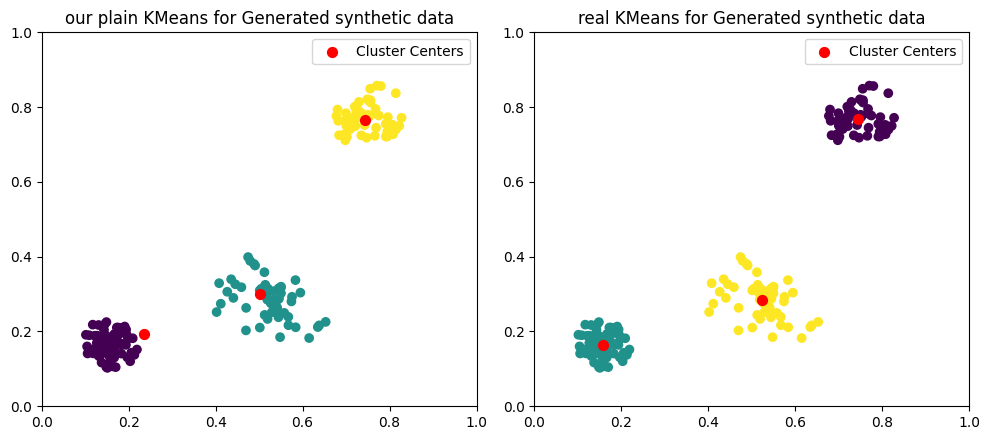

In [84]:
#plot_side_by_side(data, plain_discovered_centers, plain_discovered_labels, "our plain KMeans", true_centers, true_labels, "real KMeans", "Generated synthetic data")

In [ ]:
#plot_side_by_side(data, plain_discovered_centers, plain_discovered_labels, "our plain KMeans", true_centers, true_labels, "real KMeans", "Generated synthetic data")
#plot_side_by_side(data, cipher_discovered_centers, cipher_discovered_labels, "our encrypted KMeans", true_centers, true_labels, "real KMeans", "Generated synthetic data")

In [183]:
# put the plot next to each other

Dataset already downloaded to ./mnist_784_dataset.pkl
Dataset successfully loaded from ./mnist_784_dataset.pkl


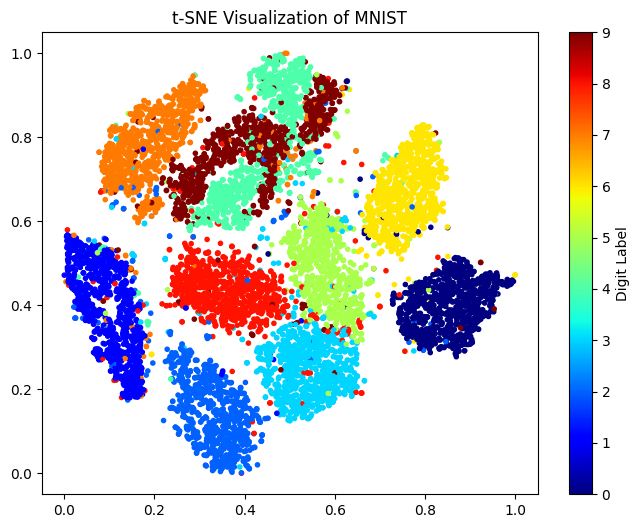

In [184]:
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler

# Load the MNIST dataset

# Download and save the dataset if not already downloaded
local_dataset_path = download_and_save_dataset("mnist_784")

# Load the dataset from the saved file
X, y = load_local_dataset(local_dataset_path)

# Define the number of samples you want to use (e.g., 5000 samples)
num_samples = 10000

# Select a random subset of the data
random_indices = np.random.choice(X.shape[0], num_samples, replace=False)
X = X[random_indices]
y = y[random_indices]


# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)


# Normalize the data to be in [0, 1]
scaler = MinMaxScaler()
X_reduced = scaler.fit_transform(X_reduced)


# Create a scatter plot for visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet', marker='.')
plt.colorbar(label='Digit Label')
plt.title("t-SNE Visualization of MNIST")
plt.show()


Looking for center number 1
Looking for center number 2
Looking for center number 3
Looking for center number 4
Looking for center number 5
Looking for center number 6
Looking for center number 7
Looking for center number 8
Looking for center number 9
Looking for center number 10


/anaconda/envs/jupyter_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


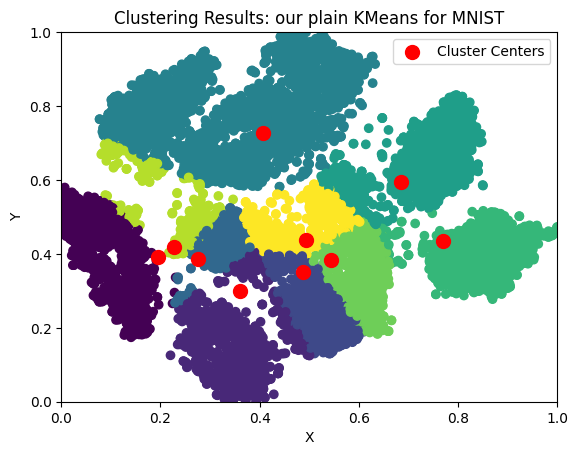

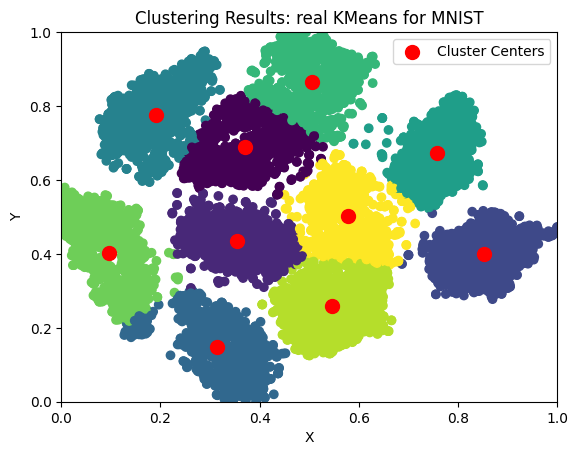

In [185]:
data = list(X_reduced)
k = 10
n = 80
initial_p, final_p = 80, 80
interval = 0.01
parameters = [k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval]

''' Plaintext Data Calculation '''
plain_discovered_centers, plain_discovered_labels, plain_total_time = run_plaintext_version(data, k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones, is_pp_case = False)


''' Encrypted Data Calculation '''
#cipher_discovered_centers, cipher_discovered_labels, cipher_total_time = run_encrypted_version(data, k, n, initial_p, final_p, iterations_for_center=5, internal_iterations=5, interval=interval, to_print=to_print, to_draw=to_draw, to_draw_milestones=to_draw_milestones, is_pp_case = True)


''' Real KMeans '''
true_centers, true_labels, kmeans_total_time = run_real_kmeans(k, data)


''' Calculate Metrics and Save Results '''
save_perf_metrics(parameters, data, plain_discovered_centers, plain_discovered_labels, true_labels, true_centers, plain_total_time, "our plain KMeans", "MNIST")
#save_perf_metrics(parameters, data, cipher_discovered_centers, cipher_discovered_labels, true_labels, true_centers, cipher_total_time, "our encrypted KMeans", "MNIST")

save_perf_metrics(parameters, data, true_centers, true_labels, true_labels, true_centers, kmeans_total_time, "real KMeans", "MNIST")


In [186]:
kmeans_total_time

0.10229992866516113

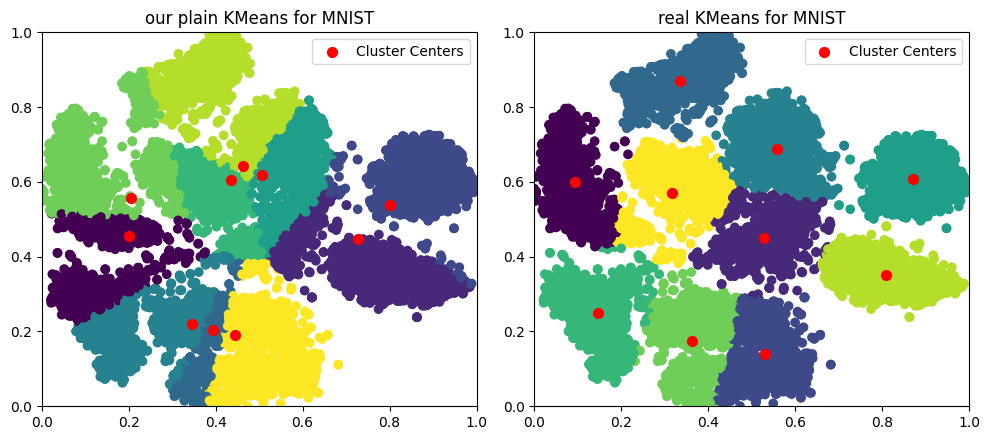

In [93]:
plot_side_by_side(data, plain_discovered_centers, plain_discovered_labels, "our plain KMeans", true_centers, true_labels, "real KMeans", "MNIST")

Looking for center number 1
Internal iteration #1, new_centers: [[0.36001603715232267, 0.5369736027797807]]
Internal iteration #2, new_centers: [[0.40601029894212304, 0.5203244326771885]]
Internal iteration #3, new_centers: [[0.4196848749556162, 0.5133160080050829]]
Internal iteration #4, new_centers: [[0.48856798887499336, 0.5771931646286784]]
Internal iteration #5, new_centers: [[0.4421112893462521, 0.5634174990540715]]
Looking for center number 2
Internal iteration #1, new_centers: [[0.46600748026750616, 0.5553545335019157]]
Internal iteration #2, new_centers: [[0.4444143674598682, 0.5105027761334744]]
Internal iteration #3, new_centers: [[0.4409160577935678, 0.5004287551347142]]
Internal iteration #4, new_centers: [[0.4474875846332148, 0.5521384854595618]]
Internal iteration #5, new_centers: [[0.4430273742684575, 0.5683204154163564]]
Internal iteration #1, new_centers: [[0.29341994552822637, 0.5539885009535035]]
Internal iteration #2, new_centers: [[0.37852386963343404, 0.494558996

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


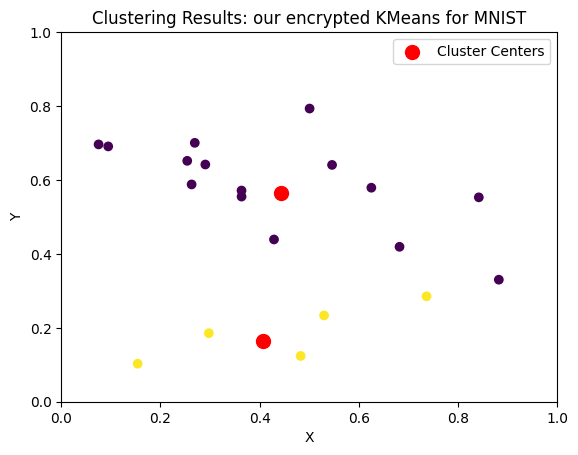

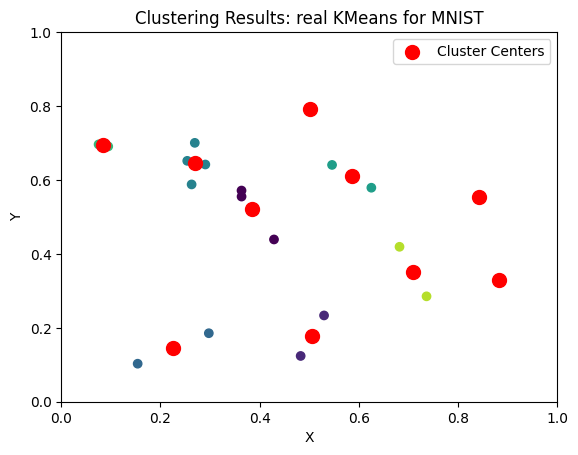

In [105]:
from random import sample
sample_data = sample(data, 20)
n = 4
initial_p, final_p = 6, 20
interval = 0.1
parameters = [k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval]
''' Plaintext Data Calculation '''
#plain_discovered_centers, plain_discovered_labels, plain_total_time = run_plaintext_version(sample_data, k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones, is_pp_case = False)


''' Encrypted Data Calculation '''
cipher_discovered_centers, cipher_discovered_labels, cipher_total_time = run_encrypted_version(sample_data, k, n, initial_p, final_p, iterations_for_center=5, internal_iterations=5, interval=interval, to_print=to_print, to_draw=to_draw, to_draw_milestones=to_draw_milestones, is_pp_case = True)


''' Real KMeans '''
true_centers, true_labels, kmeans_total_time = run_real_kmeans(k, sample_data)


''' Calculate Metrics and Save Results '''
#save_perf_metrics(parameters, sample_data, plain_discovered_centers, plain_discovered_labels, true_labels, true_centers, plain_total_time, "our plain KMeans", "MNIST")
save_perf_metrics(parameters, sample_data, cipher_discovered_centers, cipher_discovered_labels, true_labels, true_centers, cipher_total_time, "our encrypted KMeans", "MNIST")

save_perf_metrics(parameters, sample_data, true_centers, true_labels, true_labels, true_centers, kmeans_total_time, "real KMeans", "MNIST")


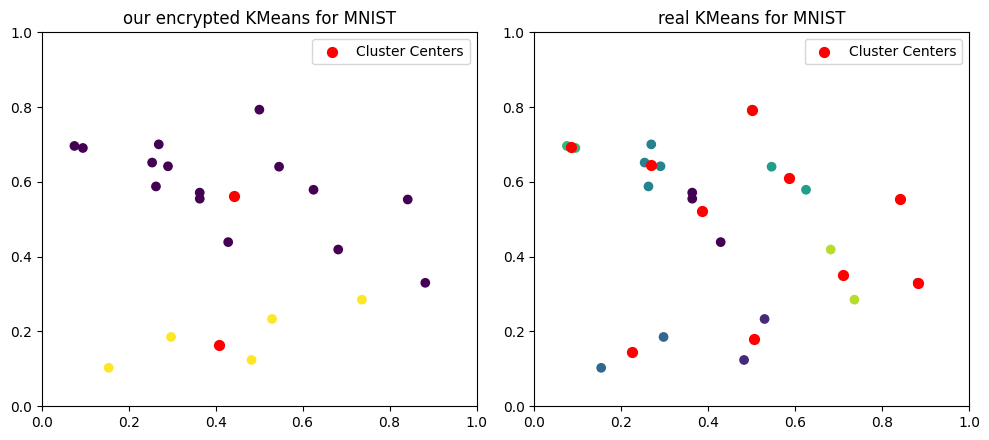

In [106]:
plot_side_by_side(sample_data, cipher_discovered_centers, cipher_discovered_labels, "our encrypted KMeans", true_centers, true_labels, "real KMeans", "MNIST")

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/sklearn/datasets/_openml.py:311: UserWarning: Multiple active versions of the dataset matching the name iris exist. Versions may be fundamentally different, returning version 1.
  warn(
/anaconda/envs/jupyter_env/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Dataset saved locally to ./iris_dataset.pkl
Dataset successfully loaded from ./iris_dataset.pkl


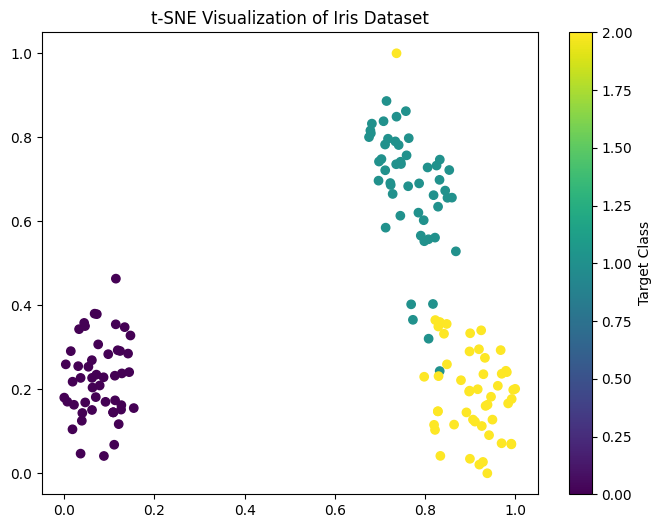

In [127]:
from sklearn.datasets import load_iris

# Download and save the dataset if not already downloaded
local_dataset_path = download_and_save_dataset("iris")

# Load the dataset from the saved file
X, y = load_local_dataset(local_dataset_path)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

# Normalize the data to be in [0, 1]
scaler = MinMaxScaler()
X_reduced = scaler.fit_transform(X_reduced)

# Create a scatter plot for visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', marker='o')
plt.colorbar(label='Target Class')
plt.title("t-SNE Visualization of Iris Dataset")
plt.show()

Looking for center number 1
Looking for center number 2
Looking for center number 3


/anaconda/envs/jupyter_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


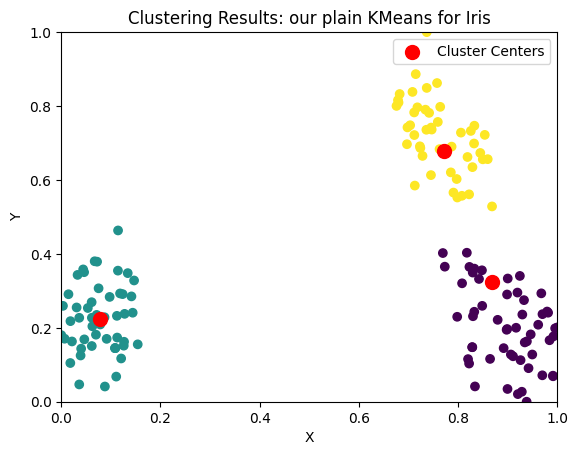

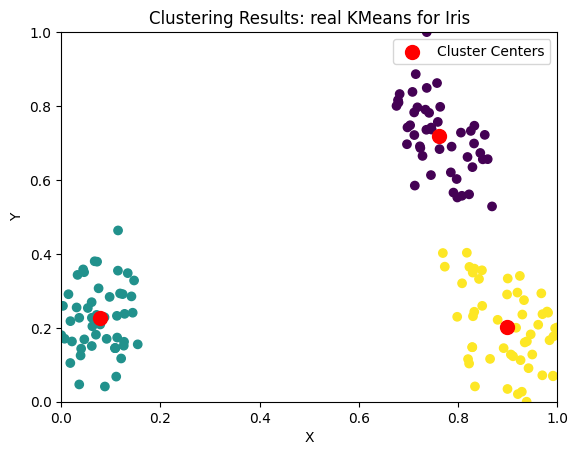

In [129]:
data = list(X_reduced)
k = 3
n = 4
initial_p, final_p = 6, 20
interval = 0.1
parameters = [k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval]

''' Plaintext Data Calculation '''
plain_discovered_centers, plain_discovered_labels, plain_total_time = run_plaintext_version(data, k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones, is_pp_case = False)


''' Encrypted Data Calculation '''
#cipher_discovered_centers, cipher_discovered_labels, cipher_total_time = run_encrypted_version(data, k, n, initial_p, final_p, iterations_for_center=5, internal_iterations=5, interval=interval, to_print=to_print, to_draw=to_draw, to_draw_milestones=to_draw_milestones, is_pp_case = True)


''' Real KMeans '''
true_centers, true_labels, kmeans_total_time = run_real_kmeans(k, data)


''' Calculate Metrics and Save Results '''
save_perf_metrics(parameters, data, plain_discovered_centers, plain_discovered_labels, true_labels, true_centers, plain_total_time, "our plain KMeans", "Iris")
#save_perf_metrics(parameters, data, cipher_discovered_centers, cipher_discovered_labels, true_labels, true_centers, cipher_total_time, "our encrypted KMeans", "Iris")

save_perf_metrics(parameters, data, true_centers, true_labels, true_labels, true_centers, kmeans_total_time, "real KMeans", "Iris")


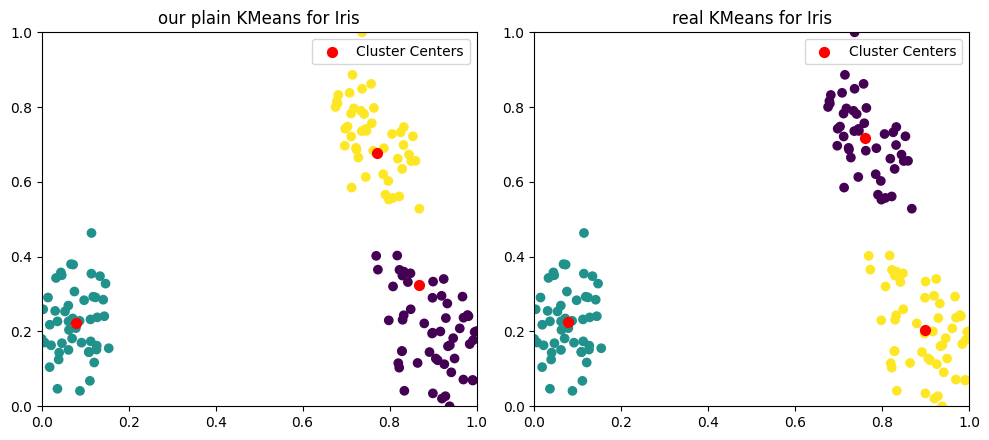

In [130]:
plot_side_by_side(data, plain_discovered_centers, plain_discovered_labels, "our plain KMeans", true_centers, true_labels, "real KMeans", "Iris")

Looking for center number 1
Internal iteration #1, new_centers: [[0.4848080077280014, 0.4487904621850467]]
Internal iteration #2, new_centers: [[0.4629583338249974, 0.38957012804300584]]
Internal iteration #3, new_centers: [[0.4264542999463544, 0.36465155329386595]]
Internal iteration #4, new_centers: [[0.45070213316810503, 0.39054152280583454]]
Internal iteration #5, new_centers: [[0.37997300566993225, 0.3622460536658368]]
Looking for center number 2
Internal iteration #1, new_centers: [[0.09926564053558459, 0.24393980815534622]]
Internal iteration #2, new_centers: [[0.13448213669729722, 0.2587083221053851]]
Internal iteration #3, new_centers: [[0.15161099445963178, 0.2650144298688266]]
Internal iteration #4, new_centers: [[0.07107650706395902, 0.2206389780242254]]
Internal iteration #5, new_centers: [[0.06305040531044286, 0.21355765453127068]]
Looking for center number 3
Internal iteration #1, new_centers: [[0.7481607446922485, 0.6476139500393406]]
Internal iteration #2, new_centers:

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


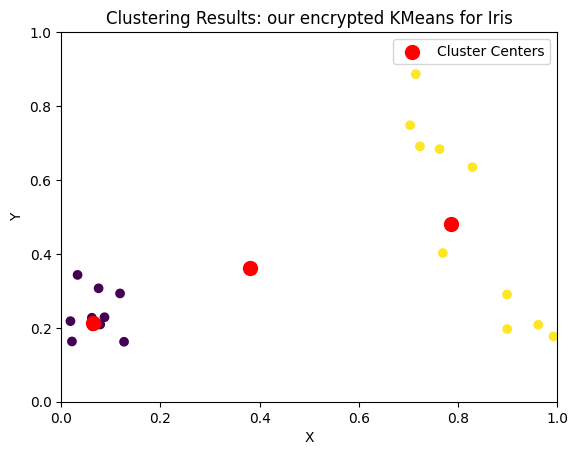

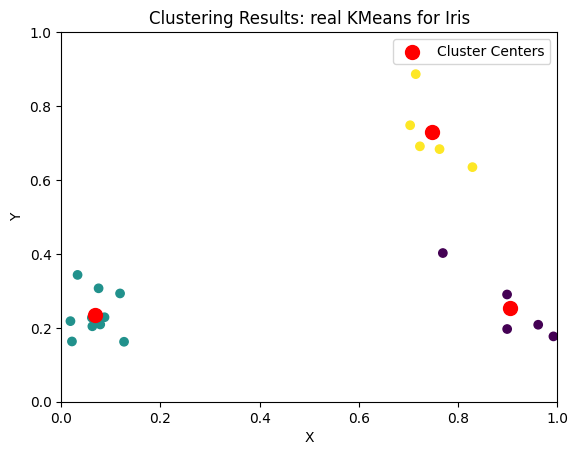

In [132]:
sample_data = sample(data, 20)

''' Plaintext Data Calculation '''
#plain_discovered_centers, plain_discovered_labels, plain_total_time = run_plaintext_version(sample_data, k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones, is_pp_case = False)


''' Encrypted Data Calculation '''
cipher_discovered_centers, cipher_discovered_labels, cipher_total_time = run_encrypted_version(sample_data, k, n, initial_p, final_p, iterations_for_center=5, internal_iterations=5, interval=interval, to_print=to_print, to_draw=to_draw, to_draw_milestones=to_draw_milestones, is_pp_case = True)


''' Real KMeans '''
true_centers, true_labels, kmeans_total_time = run_real_kmeans(k, sample_data)


''' Calculate Metrics and Save Results '''
#save_perf_metrics(parameters, sample_data, plain_discovered_centers, plain_discovered_labels, true_labels, true_centers, plain_total_time, "our plain KMeans", "Iris")
save_perf_metrics(parameters, sample_data, cipher_discovered_centers, cipher_discovered_labels, true_labels, true_centers, cipher_total_time, "our encrypted KMeans", "Iris")

save_perf_metrics(parameters, sample_data, true_centers, true_labels, true_labels, true_centers, kmeans_total_time, "real KMeans", "Iris")


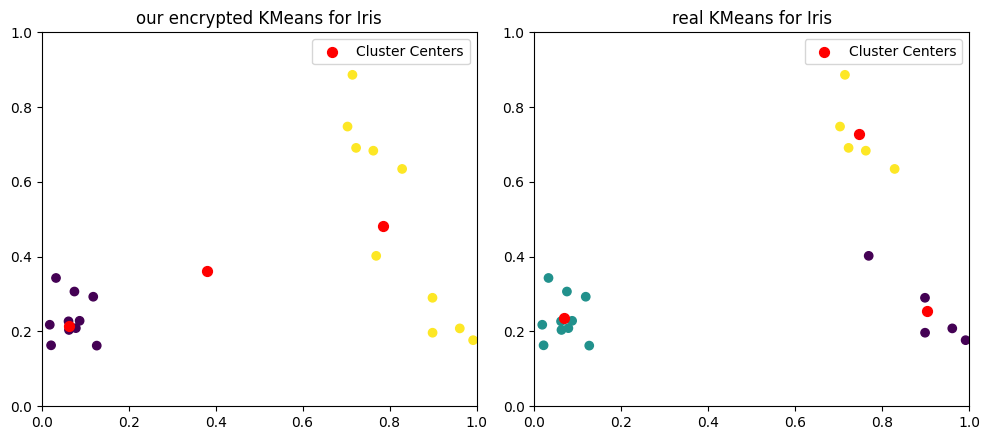

In [138]:
plot_side_by_side(sample_data, cipher_discovered_centers, cipher_discovered_labels, "our encrypted KMeans", true_centers, true_labels, "real KMeans", "Iris")

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Dataset saved locally to ./cifar_10_dataset.pkl
Dataset successfully loaded from ./cifar_10_dataset.pkl


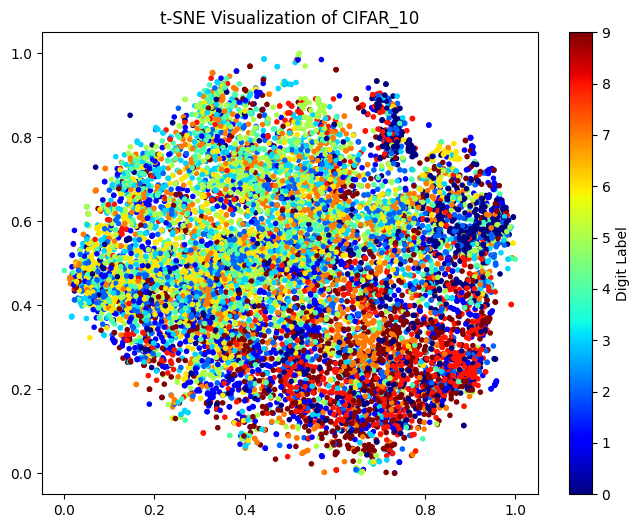

In [136]:
# Load the CIFAR_10 dataset
# Download and save the dataset if not already downloaded
local_dataset_path = download_and_save_dataset("cifar_10")

# Load the dataset from the saved file
X, y = load_local_dataset(local_dataset_path)

# Define the number of samples you want to use (e.g., 5000 samples)
num_samples = 10000

# Select a random subset of the data
random_indices = np.random.choice(X.shape[0], num_samples, replace=False)
X = X[random_indices]
y = y[random_indices]


# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)


# Normalize the data to be in [0, 1]
scaler = MinMaxScaler()
X_reduced = scaler.fit_transform(X_reduced)


# Create a scatter plot for visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet', marker='.')
plt.colorbar(label='Digit Label')
plt.title("t-SNE Visualization of CIFAR_10")
plt.show()


Looking for center number 1
Looking for center number 2
Looking for center number 3
Looking for center number 4
Looking for center number 5
Looking for center number 6
Looking for center number 7
Looking for center number 8
Looking for center number 9
Looking for center number 10


/anaconda/envs/jupyter_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


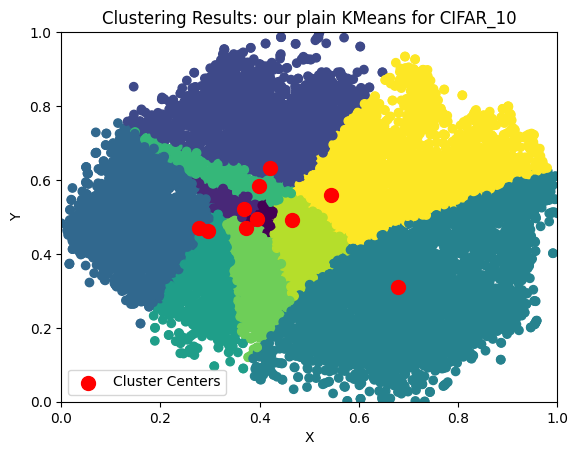

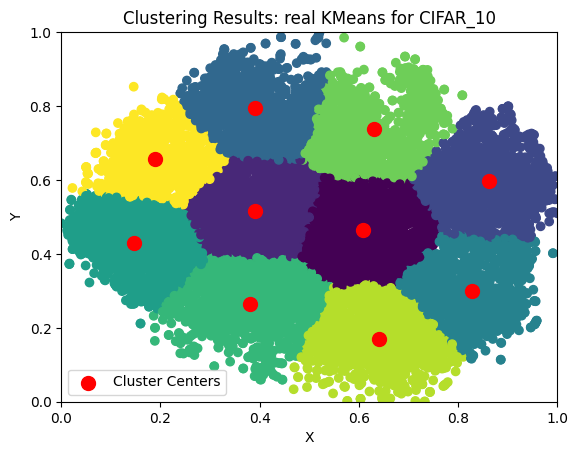

In [159]:
data = list(X_reduced)
k = 10
n = 80
initial_p, final_p = 80, 80
interval = 0.01
parameters = [k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval]

''' Plaintext Data Calculation '''
plain_discovered_centers, plain_discovered_labels, plain_total_time = run_plaintext_version(data, k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones, is_pp_case = False)


''' Encrypted Data Calculation '''
#cipher_discovered_centers, cipher_discovered_labels, cipher_total_time = run_encrypted_version(data, k, n, initial_p, final_p, iterations_for_center=5, internal_iterations=5, interval=interval, to_print=to_print, to_draw=to_draw, to_draw_milestones=to_draw_milestones, is_pp_case = True)


''' Real KMeans '''
true_centers, true_labels, kmeans_total_time = run_real_kmeans(k, data)


''' Calculate Metrics and Save Results '''
save_perf_metrics(parameters, data, plain_discovered_centers, plain_discovered_labels, true_labels, true_centers, plain_total_time, "our plain KMeans", "CIFAR_10")
#save_perf_metrics(parameters, data, cipher_discovered_centers, cipher_discovered_labels, true_labels, true_centers, cipher_total_time, "our encrypted KMeans", "CIFAR_10")

save_perf_metrics(parameters, data, true_centers, true_labels, true_labels, true_centers, kmeans_total_time, "real KMeans", "CIFAR_10")

In [164]:
kmeans_total_time

0.13624238967895508

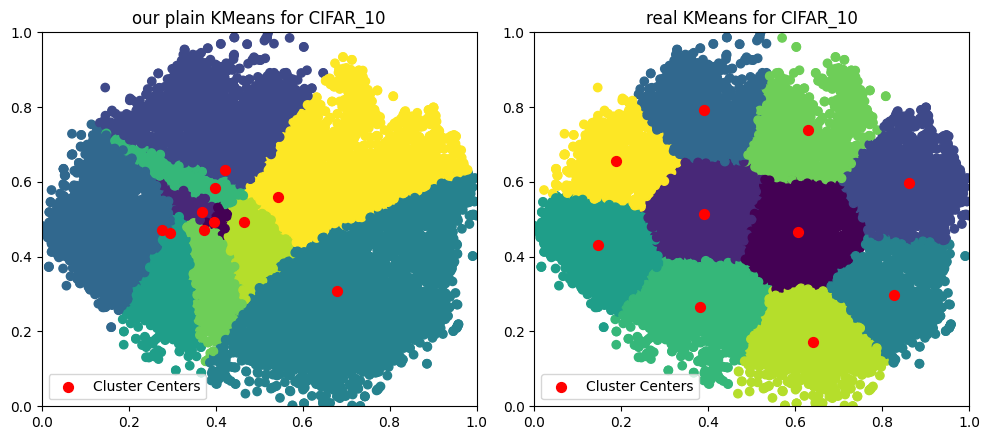

In [165]:
plot_side_by_side(data, plain_discovered_centers, plain_discovered_labels, "our plain KMeans", true_centers, true_labels, "real KMeans", "CIFAR_10")

Looking for center number 1
Internal iteration #1, new_centers: [[0.48916660441812054, 0.5458785766365124]]
Internal iteration #2, new_centers: [[0.608696566489173, 0.49260755905336373]]
Internal iteration #3, new_centers: [[0.629067506225838, 0.4803473733372018]]
Internal iteration #4, new_centers: [[0.614486570262859, 0.4581490095128078]]
Internal iteration #5, new_centers: [[0.6604416923479558, 0.49093768998989695]]
Looking for center number 2
Internal iteration #1, new_centers: [[0.6678939724397709, 0.3112584197599741]]
Internal iteration #2, new_centers: [[0.6269416901472905, 0.3865024231785853]]
Internal iteration #3, new_centers: [[0.6219404464850371, 0.4171766228048901]]
Internal iteration #4, new_centers: [[0.6098720976976282, 0.34009673349680714]]
Internal iteration #5, new_centers: [[0.5995453726339276, 0.31157762788374377]]
Looking for center number 3
Internal iteration #1, new_centers: [[0.687882628432938, 0.4119093625559945]]
Internal iteration #2, new_centers: [[0.644911

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


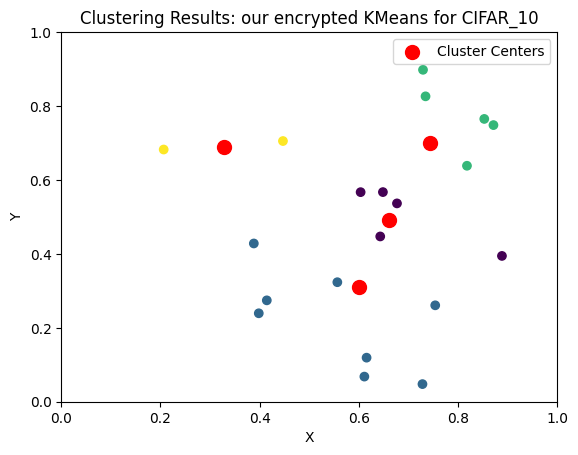

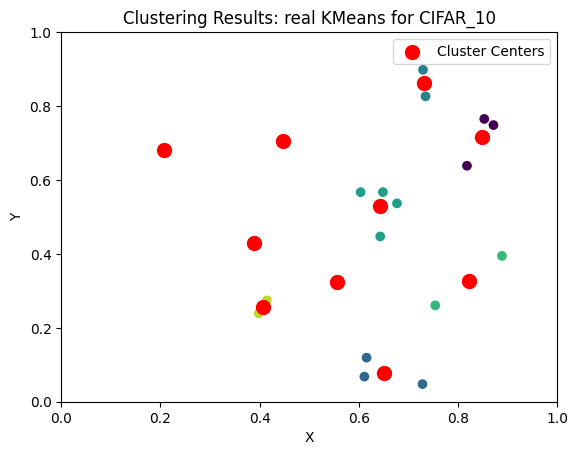

In [166]:
sample_data = sample(data, 20)
k = 10
n = 4
initial_p, final_p = 6, 20
interval = 0.1
parameters = [k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval]

''' Plaintext Data Calculation '''
#plain_discovered_centers, plain_discovered_labels, plain_total_time = run_plaintext_version(sample_data, k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones, is_pp_case = False)


''' Encrypted Data Calculation '''
cipher_discovered_centers, cipher_discovered_labels, cipher_total_time = run_encrypted_version(sample_data, k, n, initial_p, final_p, iterations_for_center=5, internal_iterations=5, interval=interval, to_print=to_print, to_draw=to_draw, to_draw_milestones=to_draw_milestones, is_pp_case = True)


''' Real KMeans '''
true_centers, true_labels, kmeans_total_time = run_real_kmeans(k, sample_data)


''' Calculate Metrics and Save Results '''
#save_perf_metrics(parameters, sample_data, plain_discovered_centers, plain_discovered_labels, true_labels, true_centers, plain_total_time, "our plain KMeans", "CIFAR_10")
save_perf_metrics(parameters, sample_data, cipher_discovered_centers, cipher_discovered_labels, true_labels, true_centers, cipher_total_time, "our encrypted KMeans", "CIFAR_10")

save_perf_metrics(parameters, sample_data, true_centers, true_labels, true_labels, true_centers, kmeans_total_time, "real KMeans", "CIFAR_10")


In [167]:
kmeans_total_time

0.020163774490356445

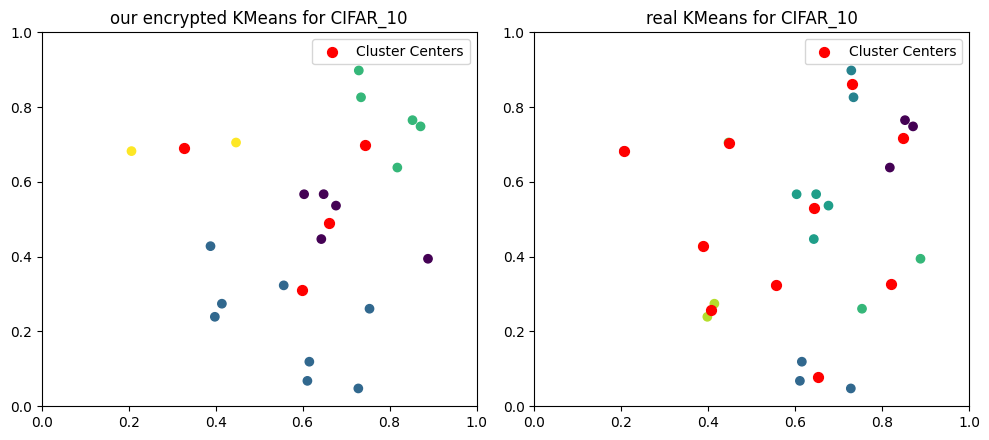

In [168]:
plot_side_by_side(sample_data, cipher_discovered_centers, cipher_discovered_labels, "our encrypted KMeans", true_centers, true_labels, "real KMeans", "CIFAR_10")

Dataset already downloaded to ./wine_dataset.pkl
Dataset successfully loaded from ./wine_dataset.pkl


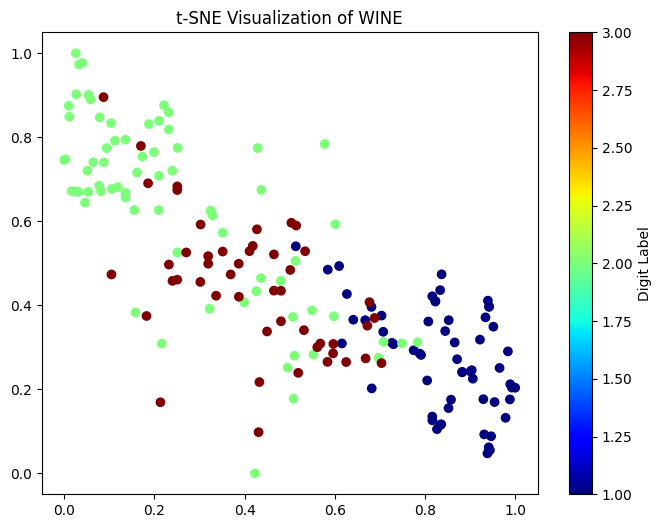

In [170]:
# Load the WINE dataset

# Download and save the dataset if not already downloaded
local_dataset_path = download_and_save_dataset("wine")

# Load the dataset from the saved file
X, y = load_local_dataset(local_dataset_path)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)


# Normalize the data to be in [0, 1]
scaler = MinMaxScaler()
X_reduced = scaler.fit_transform(X_reduced)


# Create a scatter plot for visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet', marker='o')
plt.colorbar(label='Digit Label')
plt.title("t-SNE Visualization of WINE")
plt.show()


Looking for center number 1
Looking for center number 2
Looking for center number 3


/anaconda/envs/jupyter_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


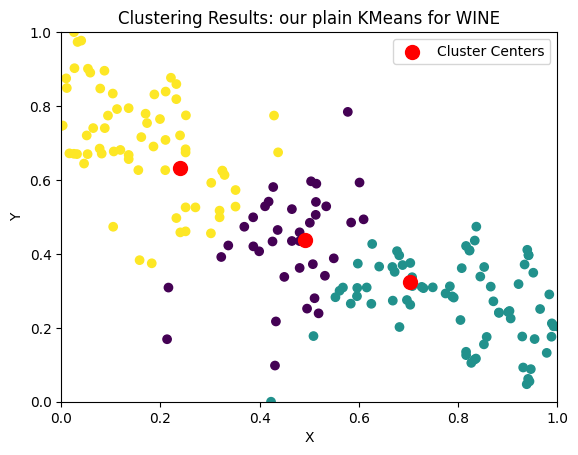

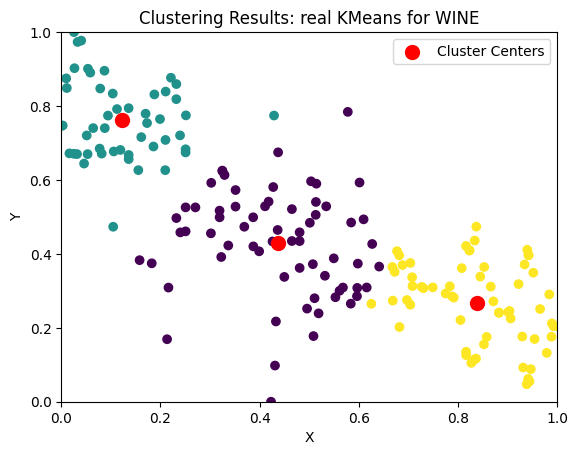

In [172]:
data = list(X_reduced)
k = 3
parameters = [k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval]

''' Plaintext Data Calculation '''
plain_discovered_centers, plain_discovered_labels, plain_total_time = run_plaintext_version(data, k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones, is_pp_case = False)


''' Encrypted Data Calculation '''
#cipher_discovered_centers, cipher_discovered_labels, cipher_total_time = run_encrypted_version(data, k, n, initial_p, final_p, iterations_for_center=5, internal_iterations=5, interval=interval, to_print=to_print, to_draw=to_draw, to_draw_milestones=to_draw_milestones, is_pp_case = True)


''' Real KMeans '''
true_centers, true_labels, kmeans_total_time = run_real_kmeans(k, data)


''' Calculate Metrics and Save Results '''
save_perf_metrics(parameters, data, plain_discovered_centers, plain_discovered_labels, true_labels, true_centers, plain_total_time, "our plain KMeans", "WINE")
#save_perf_metrics(parameters, data, cipher_discovered_centers, cipher_discovered_labels, true_labels, true_centers, cipher_total_time, "our encrypted KMeans", "WINE")

save_perf_metrics(parameters, data, true_centers, true_labels, true_labels, true_centers, kmeans_total_time, "real KMeans", "WINE")

In [173]:
kmeans_total_time

0.012621641159057617

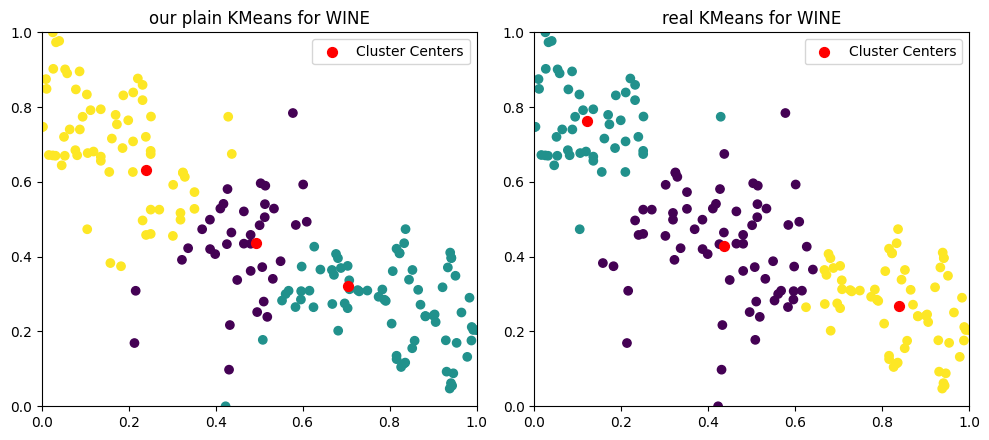

In [176]:
plot_side_by_side(data, plain_discovered_centers, plain_discovered_labels, "our plain KMeans", true_centers, true_labels, "real KMeans", "WINE")

Looking for center number 1
Internal iteration #1, new_centers: [[0.3835709966112145, 0.5687421795807708]]
Internal iteration #2, new_centers: [[0.42960106911139245, 0.5477318096156775]]
Internal iteration #3, new_centers: [[0.4635964023138585, 0.5261674963851395]]
Internal iteration #4, new_centers: [[0.4656179783017782, 0.512260093823618]]
Internal iteration #5, new_centers: [[0.5110110778828635, 0.49392999253027425]]
Looking for center number 2
Internal iteration #1, new_centers: [[0.3181266932366641, 0.6006179686785201]]
Internal iteration #2, new_centers: [[0.3705086804648381, 0.5821204059746827]]
Internal iteration #3, new_centers: [[0.4095092913259933, 0.5572880953795056]]
Internal iteration #4, new_centers: [[0.43057029079050446, 0.5523864515082836]]
Internal iteration #5, new_centers: [[0.44480584681746643, 0.5441631564250471]]
Internal iteration #1, new_centers: [[0.21210256588920784, 0.6899303931118372]]
Internal iteration #2, new_centers: [[0.23148657987194216, 0.6708640541

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


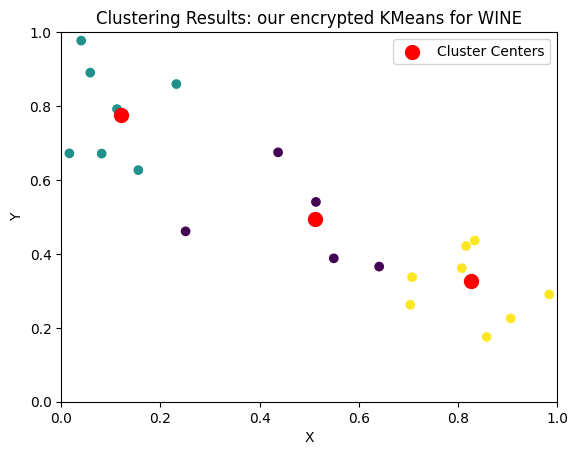

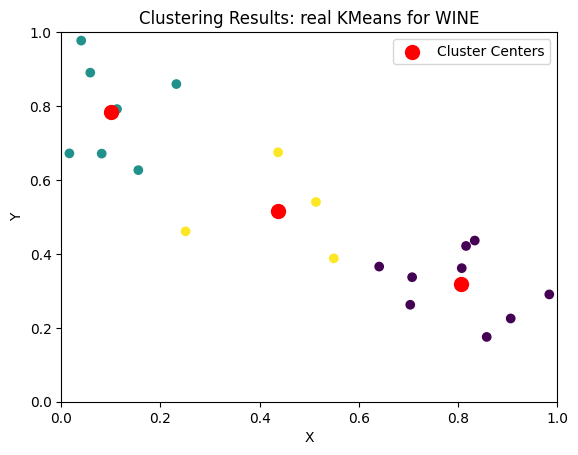

In [178]:
sample_data = sample(data, 20)

parameters = [k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval]

''' Plaintext Data Calculation '''
#plain_discovered_centers, plain_discovered_labels, plain_total_time = run_plaintext_version(sample_data, k, n, initial_p, final_p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones, is_pp_case = False)


''' Encrypted Data Calculation '''
cipher_discovered_centers, cipher_discovered_labels, cipher_total_time = run_encrypted_version(sample_data, k, n, initial_p, final_p, iterations_for_center=5, internal_iterations=5, interval=interval, to_print=to_print, to_draw=to_draw, to_draw_milestones=to_draw_milestones, is_pp_case = True)


''' Real KMeans '''
true_centers, true_labels, kmeans_total_time = run_real_kmeans(k, sample_data)


''' Calculate Metrics and Save Results '''
#save_perf_metrics(parameters, sample_data, plain_discovered_centers, plain_discovered_labels, true_labels, true_centers, plain_total_time, "our plain KMeans", "WINE")
save_perf_metrics(parameters, sample_data, cipher_discovered_centers, cipher_discovered_labels, true_labels, true_centers, cipher_total_time, "our encrypted KMeans", "WINE")

save_perf_metrics(parameters, sample_data, true_centers, true_labels, true_labels, true_centers, kmeans_total_time, "real KMeans", "WINE")


In [179]:
kmeans_total_time

0.00942850112915039

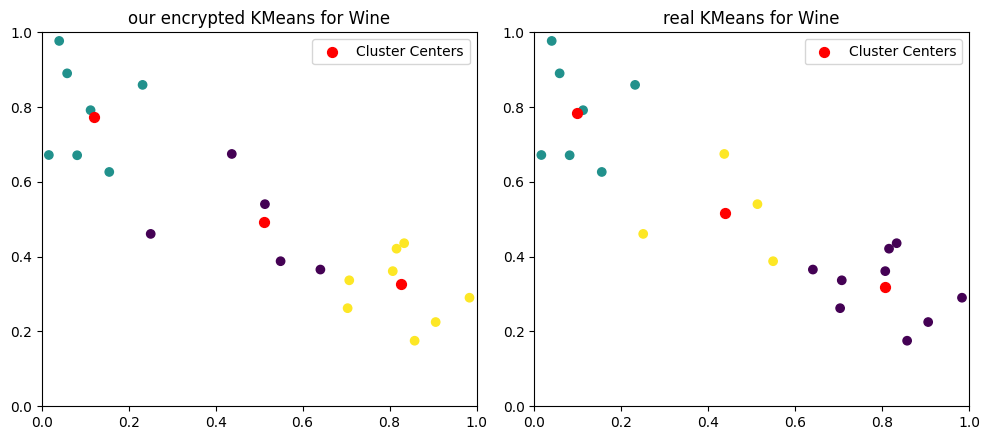

In [180]:
plot_side_by_side(sample_data, cipher_discovered_centers, cipher_discovered_labels, "our encrypted KMeans", true_centers, true_labels, "real KMeans", "Wine")